<H2>6. 작사가 인공지능 만들기</h2>
이번 노드에서는 다음의 문항을 기준으로 수행하겠다.

1. 데이터의 전처리 및 구성과정이 체계적으로 진행되었는가?

- 특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?

2. 가사 텍스트 생성 모델이 정상적으로 동작하는가?

- 텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?

3. 텍스트 생성모델이 안정적으로 학습되었는가?

- 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?


목표 : 각 소설의 문장들을 통해 새로운 문장을 모델을 통해 "생성"하는 것 

수행해야할 과정 : 각 소설의 문장들을 가져와서 정제하고, 모델에 넣어서 학습하고, 예측하듯이 새로운 문장을 "생성"한다.

루브릭

- 데이터 전처리시, 특수문자 제거, tokenizer 생성, padding 처리 

- textGenerator로 생성된 문장이 우리눈으로 보기에 해석가능한가 

-  생성모델이 안정적으로 학습되었는지 (val loss 2.2이하) - train과정에서 validation 비율을 주고 plot을 통해 시각화하자.



목차 

- 데이터 다운로드

- 데이터 읽어오기 : raw_corpus에 각 줄별로 저장.
 
- 데이터 정제 

먼저 lyrics 파일에있는 소설의 txt파일들을 가져와서 다룰 것이다.

파일들을 glob을 통해 가져온 다음에는, 각 splitlines별로 raw_corpus에 추가해준다.

데이터 그 자체들은 raw_corpus에 저장되게 된다.

In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow as tf
import os
import re
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


Step 1. 데이터 다운로드 /aiffel/lyricist/data/lyrics

Step 2. 데이터 읽어오기 glob을 통해 읽어온다

In [2]:
txt_file_path = os.getenv("HOME")+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = []
# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.

for txt_file in txt_list:
    with open(txt_file,"r")as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
    
print("데이터 크기 : ", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기 :  187088
Examples:
 ["Busted flat in Baton Rouge, waitin' for a train", "And I's feelin' near as faded as my jeans", 'Bobby thumbed a diesel down, just before it rained']


Step 3. 데이터 정제

입력된 문장을
1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
2. 특수문자 양쪽에 공백을 넣고
3. 여러개의 공백은 하나의 공백으로 바꿉니다
4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
5. 다시 양쪽 공백을 지웁니다
6. 문장 시작에는 < start >, 끝에는 < end >를 추가합니다


In [3]:
#데이터 정제하는 함수 preprocess_sentence
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() #1 소문자로 바꾸고 양쪽공백 제거
    sentence = re.sub(r"([?.!,¿])",r"\1", sentence) #2
    sentence = re.sub(r'[" "]+'," ",sentence) #3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)#4
    sentence = sentence.strip() #5
    sentence = '<start> ' + sentence +' <end>'#6
    return sentence
print(preprocess_sentence("This @_is ;;; sample      sentence"))
    

<start> this is sample sentence <end>


정제된 문장을 corpus에 모으는데, 

조건으로 

- 공백인 문장, 

- 마지막 단어가:인 문장,

- 단어 토큰이 15개이상인 문장, 

이 문장들은 학습데이터에서 제외된다.

그리고 선별된 문장들을 앞의 전처리 함수를 이용해 문장을 정제한 뒤, corpus에 append해서 모은다.


In [4]:
#여기에 정제된 문장을 모은다
corpus = []
max_len=15
#raw_corpus_list에 저장된 문장들 순서대로 반환하여 sentence에 저장한다.
#문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.
for sentence in raw_corpus:
    #우리가 원하지 않는 문장 패스
    if len(sentence) == 0: continue
    if sentence[-1]==':':continue
    if len(sentence) >=15: continue
        
    #앞서 구현한 함수 prerocess_sentence() 함수를 이용하여 문장을 정제, 담는다
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

In [5]:
corpus[:10]

['<start> la da da da <end>',
 '<start> hey, my bobby <end>',
 '<start> hey, my bobby <end>',
 '<start> oh yes indeed. <end>',
 '<start> la da da da <end>',
 '<start> hey, my bobby <end>',
 '<start> hey, my bobby <end>',
 '<start> oh yes indeed. <end>',
 '<start> i promise. <end>',
 '<start> whoa babe, <end>']

사용할 문장들을 모았다면 다음엔 토큰화를 시켜야한다.

단어 12000개로 제한하고, 텍스트->토큰화를 진행한다

fit_on_texts를 통해 corpus의 문장들을 리스트의 형태로 변환한다.

texts_to_sequences를 통해 문장들의  단어들을 숫자 시퀀스 형태로 변환한다.

시퀀스들의 길이를 일정하게 맞추기위해 패딩을 붙힌다.

그리고 tensor와 tokenizer을 return한다.

In [6]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    #7000단어 기억하는 tokenizer만들것
    #문장은 이미 정제되서 filter필요없다
    #7000단어에 포함안되는 단어는 <unk>
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
                num_words=12000,
                filters=' ',
                oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus) 
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    print(tensor,tokenizer)
    return tensor, tokenizer
tensor, tokenizer = tokenize(corpus)

[[   2   46   27 ...    0    0    0]
 [   2  129   11 ...    0    0    0]
 [   2  129   11 ...    0    0    0]
 ...
 [   2   92    3 ...    0    0    0]
 [   2 3543    3 ...    0    0    0]
 [   2    3    0 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f8b49462310>


In [7]:
print(len(tensor[0]))

9


In [8]:
#print(tokenizer.index_word) #말그대로 토크나이저의 단어장이다. dict모양으로  index : 'word' 형태로 되어있다.
print(type(tokenizer.index_word[1])) 
print(tokenizer.index_word[1]) # 7 : 'oh' 의 데이터다.

<class 'str'>
<unk>


In [9]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : you
6 : it
7 : oh
8 : me
9 : a
10 : the


Step 4. 평가 데이터셋 분리

train : val : test = 6 : 2 : 2

In [10]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:,:-1]
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:,1:]

In [11]:
len(src_input)#12147,8

12147

In [12]:
len(tgt_input)#12147,8

12147

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_rem, y_train, y_rem = train_test_split(src_input, tgt_input, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test =  train_test_split(x_rem, y_rem, test_size=0.5, random_state=42) 

나중에 model.fit에 사용할 train과 val data들을 각각 텐서로 만들고 배치한다.

In [14]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
print(x_train.shape)
print(y_train.shape)
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
print(val_dataset)

(7288, 8)
(7288, 8)
<BatchDataset shapes: ((256, 8), (256, 8)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((256, 8), (256, 8)), types: (tf.int32, tf.int32)>


In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding=tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다! 

embedding_size=256  # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size=1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

TextGenrator을 통해 model에 넣습니다. (모델 층 설정)

In [16]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 8, 12001), dtype=float32, numpy=
array([[[-2.91267825e-05, -1.19322998e-04,  3.92294278e-05, ...,
          1.21089317e-04,  1.74979257e-04,  9.30213573e-05],
        [-1.52461958e-04, -3.90336616e-04,  1.78138434e-04, ...,
          2.22294242e-04,  3.62141727e-04,  2.09300022e-04],
        [-3.24215012e-04, -5.92029712e-04,  4.29409934e-04, ...,
          1.45138561e-04,  4.59116738e-04,  1.49460131e-04],
        ...,
        [-5.17292283e-05, -2.00751907e-04,  6.74095529e-04, ...,
          1.52885550e-05,  7.92512961e-04, -1.60317533e-04],
        [-1.57222836e-04,  2.24211341e-04,  4.35719034e-04, ...,
         -1.45922342e-04,  6.51543436e-04,  8.32149453e-05],
        [-3.18861363e-04,  6.63321873e-04,  2.32218605e-04, ...,
         -3.02185246e-04,  4.59815783e-04,  4.08117252e-04]],

       [[-2.91267825e-05, -1.19322998e-04,  3.92294278e-05, ...,
          1.21089317e-04,  1.74979257e-04,  9.30213573e-05],
        [-5.78567960e-05, -2.84684447e-05, -3.

In [17]:
#훈련데이터와 테스트데이터 분리 완료

Step 5. 인공지능 만들기

In [18]:
optimizer = tf.keras.optimizers.Adam()
#Loss
# tf.keras.losses.SparseCategoricalCrossentropy : https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.


In [19]:
model.compile(loss = loss, optimizer = optimizer)

In [20]:
dataset

<BatchDataset shapes: ((256, 8), (256, 8)), types: (tf.int32, tf.int32)>

모델을 학습시키고 저장한다 (매번 학습시키기에는 시간이 오래걸리기 때문이다.)

근데 수행을 해보니 h5파일로 만들려면 함수형 모델이나 순차형 모델이여야 한다고 한다. 안전하게 serialize화도 불가능.

Tensorflow SavedModel로 해보라는 듯 하다.

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not 

work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable.

Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

오류 힌트를 통해 model.save 뒤에 save_format='tf'를 지정한다

------

이렇게 수행하였으나 다시 오류가 발생했기에 save만 해보고 load는 하지않는걸로 넘어가겠다.


In [21]:
# 한번만 실행하자 오래걸리므로, 아래에 h5파일 load_model을 통해 predict 테스트 할수 있게 따로 마련해 놓았다.
history = model.fit(dataset, validation_data=val_dataset, epochs=30, verbose=2) #val_dataset 또한 fit해서 val_loss를 본다.

#from keras.models import load_model
#model.save('exp6 model')



Epoch 1/30
28/28 - 6s - loss: 4.3222 - val_loss: 2.8621
Epoch 2/30
28/28 - 3s - loss: 2.4927 - val_loss: 2.4483
Epoch 3/30
28/28 - 3s - loss: 2.1475 - val_loss: 2.2008
Epoch 4/30
28/28 - 3s - loss: 1.9630 - val_loss: 2.0988
Epoch 5/30
28/28 - 3s - loss: 1.8840 - val_loss: 2.0623
Epoch 6/30
28/28 - 3s - loss: 1.8379 - val_loss: 2.0428
Epoch 7/30
28/28 - 3s - loss: 1.8120 - val_loss: 2.0349
Epoch 8/30
28/28 - 3s - loss: 1.7909 - val_loss: 2.0337
Epoch 9/30
28/28 - 3s - loss: 1.7761 - val_loss: 2.0297
Epoch 10/30
28/28 - 3s - loss: 1.7564 - val_loss: 2.0227
Epoch 11/30
28/28 - 3s - loss: 1.7357 - val_loss: 2.0131
Epoch 12/30
28/28 - 3s - loss: 1.7186 - val_loss: 2.0050
Epoch 13/30
28/28 - 3s - loss: 1.6956 - val_loss: 2.0017
Epoch 14/30
28/28 - 3s - loss: 1.6737 - val_loss: 1.9770
Epoch 15/30
28/28 - 3s - loss: 1.6485 - val_loss: 1.9720
Epoch 16/30
28/28 - 3s - loss: 1.6247 - val_loss: 1.9585
Epoch 17/30
28/28 - 3s - loss: 1.6054 - val_loss: 1.9486
Epoch 18/30
28/28 - 3s - loss: 1.5833 - 

validation loss값이 2.2이하로 낮아졌다.

<class 'dict'>


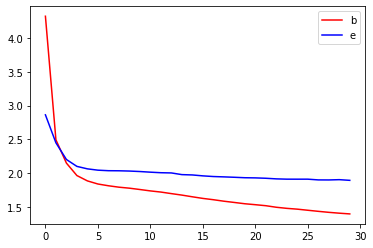

In [22]:
print(type(history.history))
plt.plot(history.history['loss'],'r',history.history['val_loss'],'b')
plt.legend('best')
plt.show()

In [23]:
#h5 파일을 불러와서 model에 적용, 이를 통해 텍스트 생성을 진행한다
#from keras.models import load_model
#model = load_model('exp6 model')
#아래 generate_text에서 제대로 수행되지 않기에 주석처리하고 넘어가겠다.

gernerate_text, 문장생성 함수에서 수행하는것은 입력받은 단어를 시퀀스로 변환한 뒤, 텐서로 변환합니다.

그리고 마지막 토큰 end_token에는 < end >의 index를 저장합니다

단어 하나씩 예측해서 문장을 만드는 구조이고 Embedding LSTM LSTM linear

1. 입력받은 문장의 텐서를 입력 

2. 예측된 값중에 가장 높은 확률인 word의 index를 뽑아냅니다. tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]

3. 2에서 예측된 word의 index를 test_tensor 문장 뒤에 붙입니다.

이후 1,2,3을 반복하다가 

4. 예측된 단어가 end_token이라면 탈출, test_tensor의 길이가 max_len보다 길면 탈출합니다.

최종적으로 tokenizer을 이용해 word_index를 단어로 하나씩 변환합니다!




In [24]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): 
    #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [25]:
generate_text(model, tokenizer, init_sentence="<start> i love ", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i love you <end> '

 <h2>회고</h2>
 
 여러가지 과정을 거쳐서 진행을 해보려했지만 안되었던 것이 많았던것 같다
 
 우선 학습이 오래걸리는 모델을 저장해서 load_model을 통해 불러와 텍스트생성을 해보려했지만
 
 오류가 떠서 주석처리를 해 보류하였다.
 
 그리고 하나 잘못생각했던게 있는것같은게 생성모델의 정확성이라던가는 컴퓨터가 판단하는게 이상한데, accuracy를 검사해보려 헀던것이다
 
 사람이 생성된 문장을 보고 이상함을 느끼는 주관적인 판단이 곧 이 생성모델의 wrong이 아닐까 싶다.
 
 일단 지식이 얕아 이렇게까지 알아보겠다.